In [13]:
import os
if not os.path.exists("portfolio-optimizer-notebooks"):
    !git clone https://github.com/drewtilley/portfolio-optimizer-notebooks.git
# Install dependencies
!pip install -r portfolio-optimizer-notebooks/requirements.txt

# Add the utils path to Python's module search path
import sys
sys.path.append("portfolio-optimizer-notebooks/utils")

Cloning into 'portfolio-optimizer-notebooks'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 33 (delta 11), reused 25 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 472.66 KiB | 4.97 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
# Module Imports
import PortfolioOptimizer
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Display Settings
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline


### Portfolio Optimization with Blue Water Macro Data

This notebook demonstrates how to use the `PortfolioOptimizer` module to build optimized portfolios using Blue Water Macro data. The goal is to:

1. Provide portfolio optimization tools using curated return and risk data
2. Support multiple risk model frameworks (historical, factor-based, etc.)
3. Enable flexible optimization criteria (e.g., Sharpe maximization, minimum variance)

The `PortfolioOptimizer` module is built **on top of** [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/), a powerful but complex portfolio optimization library. `PortfolioOptimizer` simplifies the interface, allowing users to run common portfolio construction workflows without dealing with Riskfolio's detailed configuration.


**Input Data: Xarray Dataset**

The PortfolioOptimizer expects an input in the form of an xarray.Dataset, which contains the necessary financial data (e.g., returns, factor exposures, etc.). To keep the interface clean and flexible, the optimizer assumes that the user has already sliced the dataset to the desired date range and set of tickers before passing it in.

In [4]:
# URL: the Testing dataset has a year of history for 10 large cap stocks
url = 'https://storage.googleapis.com/rm_public_csv/Testing.csv'

In [6]:
# Testing dataset is shared as a csv authenticated users have access to xarray datasets
rm_demo_df = pd.read_csv(url,
                         index_col=['date', 'ticker'],
                         parse_dates=['date'],
                         date_format='%Y-%m-%d'
                        )

# Create xarray dataset for the optimizer
rm_demo_ds = xr.Dataset.from_dataframe(rm_demo_df)

In [6]:
# Check that the data is loaded correctly
display(pd.concat([rm_demo_df.head(10), rm_demo_df.tail(10)]))

bw_sector_code          bw_sector_name    close  \
date       ticker                                                    
2024-06-20 NFLX              45.0  Information_Technology   679.03   
           UNH               35.0             Health_Care   484.52   
           NVDA              45.0  Information_Technology   130.78   
           JNJ               35.0             Health_Care   147.78   
           AMZN              25.0  Consumer_Discretionary   186.10   
           JPM               40.0              Financials   198.67   
           XOM               10.0                  Energy   111.74   
           META              45.0  Information_Technology   501.70   
           PG                30.0        Consumer_Staples   167.67   
           GOOG              45.0  Information_Technology   177.71   
2025-06-18 NFLX              45.0  Information_Technology  1222.29   
           UNH               35.0             Health_Care   307.20   
           NVDA              45.0  Information_Technology   145.48   
           JNJ               35.0             Health_Care   150.73   
           AMZN              25.0  Consumer_Discretionary   212.52   
           JPM               40.0              Financials   273.96   
           XOM               10.0                  Energy   113.19   
           META              45.0  Information_Technology   695.77   
           PG                30.0        Consumer_Staples   158.02   
           GOOG              45.0  Information_Technology   173.98   

                   cross_term_risk_pct  etf_mkt_beta  gross_return_variance  \
date       ticker                                                             
2024-06-20 NFLX               0.004155      1.309033               4.782536   
           UNH                0.003977      0.566217               1.786410   
           NVDA               0.015255      1.309033               7.752535   
           JNJ                0.005828      0.566217               1.032109   
           AMZN               0.002411      1.175337               3.029408   
           JPM                0.031164      0.781520               1.176447   
           XOM                0.013093      0.456429               1.678766   
           META               0.003091      1.309033               5.087494   
           PG                 0.006325      0.373177               0.738789   
           GOOG               0.003534      1.309033               3.043744   
2025-06-18 NFLX               0.002076      1.282467               4.134276   
           UNH                0.000259      0.499822               7.785646   
           NVDA               0.008120      1.282467              13.415474   
           JNJ                0.001055      0.499822               1.418358   
           AMZN               0.006265      1.182237               4.748329   
           JPM                0.015320      0.814214               3.133251   
           XOM                0.013064      0.767930               2.252627   
           META               0.003064      1.282467               5.438071   
           PG                 0.005043      0.354155               1.461459   
           GOOG               0.003018      1.282467               3.893928   

                   market_beta  market_contr_variance  market_factor_return  \
date       ticker                                                             
2024-06-20 NFLX       1.214309               0.888269               -0.2717   
           UNH        0.260285               0.067958               -0.2717   
           NVDA       2.313531               1.978843               -0.2717   
           JNJ        0.210629               0.034038               -0.2717   
           AMZN       1.392119               1.222697               -0.2717   
           JPM        0.649675               0.289884               -0.2717   
           XOM        0.360800               0.113143               -0.2717   
           META       1.6428

In [7]:
# Test the optimizer using equal weighted historical calculations of mean variance
classic_mvo = PortfolioOptimizer.ClassicOptimizer(rm_demo_ds)

In [8]:
# Optimize on residual returns, portfolio is not leveraged
classic_mvo.optimize(returns_col='residual_return', LongOnly=False)

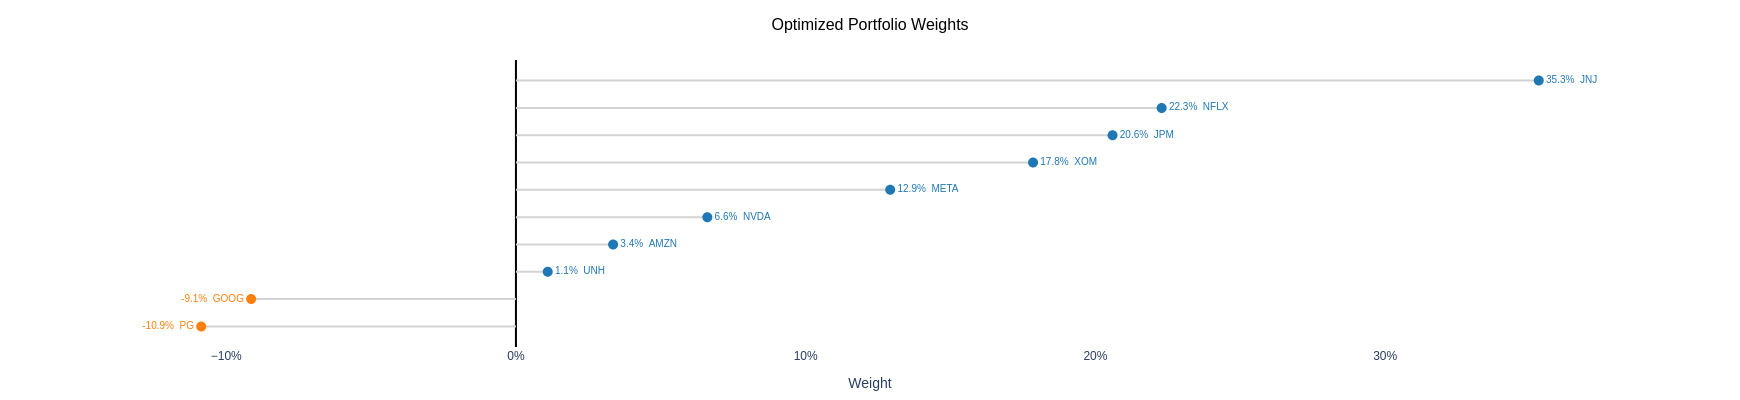

In [9]:
# Visualize optimalized weights 
classic_mvo.plot_weights_plotly()

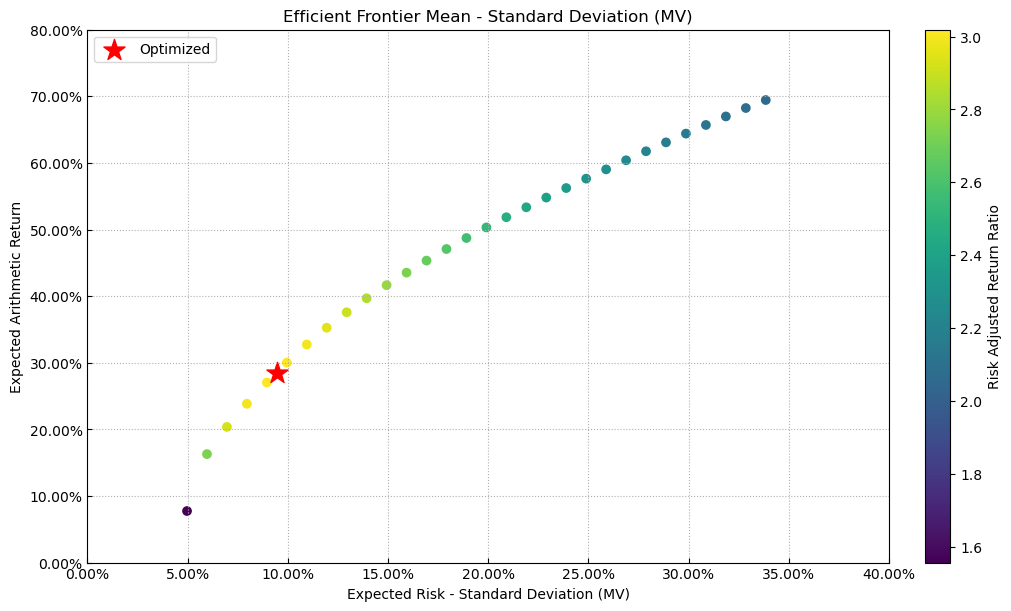

In [10]:
classic_mvo.plot_frontier()

In [11]:
classic_mvo.w.sum()

weights    1.0
dtype: float64

In [12]:
classic_mvo.port.budget

1.0

### Construction of the Covariance Matrix (Σ)

The total asset return covariance matrix **Σ** is constructed using the factor model equation:

$$
\Sigma = BFB^\top + D
$$

Where:

* **B** is the matrix of asset exposures to systematic risk factors (e.g., market, sector).
* **F** is the **factor covariance matrix**, computed from historical factor returns.
* **D** is the **diagonal residual variance matrix**, containing the idiosyncratic risk of each asset.

This formulation decomposes total risk into:

* **Systematic risk**, driven by common factor exposures (captured by $BFB^\top$),
* **Idiosyncratic risk**, unique to each asset (captured by D).

### Construction of Expected Returns (μ)

In this model, the expected return vector **μ** is calculated using the equation:

$$
\mu = B \cdot f
$$

Where:

* **B** is the matrix of asset exposures to systematic risk factors (e.g., market, sectors).
* **f** is the vector of expected returns for each factor, typically computed as the average of trailing factor returns.

This approach estimates the **gross expected return** of each asset **based solely on its factor exposures**.
It **does not include residual (idiosyncratic) components**, which are captured separately in the residual variance matrix **D**.

In [13]:
factor_model = PortfolioOptimizer.FactorModelOptimizer(rm_demo_ds)

In [14]:
factor_model.validate_config() # Accept FM defaults
factor_model.calculate_fm_cov()

In [15]:
factor_model.B

,market_beta,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Information_Technology
ticker,,,,,,,
AMZN,1.279137,0.922753,0.000000,0.000000,0.000000,0.000000,0.000000
GOOG,1.004298,0.000000,0.000000,0.000000,0.000000,0.000000,0.600650
JNJ,0.060335,0.000000,0.000000,0.000000,0.000000,1.011271,0.000000
JPM,0.880639,0.000000,0.000000,0.000000,1.070058,0.000000,0.000000
META,1.407166,0.000000,0.000000,0.000000,0.000000,0.000000,0.530078
NFLX,0.851564,0.000000,0.000000,0.000000,0.000000,0.000000,0.514257
NVDA,1.735625,0.000000,0.000000,0.000000,0.000000,0.000000,2.960326
PG,0.229182,0.000000,1.117728,0.000000,0.000000,0.000000,0.000000
UNH,0.074634,0.000000,0.000000,0.000000,0.000000,0.946002,0.000000


In [16]:
factor_model.f

,f
Market,0.000475
Consumer_Discretionary,0.000245
Consumer_Staples,0.000098
Energy,-0.000025
Financials,0.000589
Health_Care,-0.000476
Information_Technology,-0.000282


In [17]:
factor_model.F

,Market,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Information_Technology
Market,0.000167,-2.372305e-05,-0.000003,0.000040,9.363876e-06,0.000014,-0.000015
Consumer_Discretionary,-0.000024,5.605051e-05,-0.000003,-0.000020,-2.287985e-07,-0.000013,-0.000003
Consumer_Staples,-0.000003,-2.947498e-06,0.000061,0.000003,1.565338e-05,0.000035,-0.000031
Energy,0.000040,-2.028537e-05,0.000003,0.000162,2.948123e-05,0.000010,-0.000029
Financials,0.000009,-2.287985e-07,0.000016,0.000029,5.560873e-05,0.000015,-0.000031
Health_Care,0.000014,-1.253157e-05,0.000035,0.000010,1.471170e-05,0.000067,-0.000030
Information_Technology,-0.000015,-3.170185e-06,-0.000031,-0.000029,-3.148435e-05,-0.000030,0.000047


In [18]:
factor_model.D

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.015399,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
GOOG,0.000000,0.023083,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
JNJ,0.000000,0.000000,0.008211,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
JPM,0.000000,0.000000,0.000000,0.007085,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
META,0.000000,0.000000,0.000000,0.000000,0.024252,0.00000,0.000000,0.000000,0.000000,0.000000
NFLX,0.000000,0.000000,0.000000,0.000000,0.000000,0.02802,0.000000,0.000000,0.000000,0.000000
NVDA,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.024818,0.000000,0.000000,0.000000
PG,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.005799,0.000000,0.000000
UNH,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.066752,0.000000


In [19]:
factor_model.sigma

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.015664,0.000179,0.000017,0.000181,0.000257,0.000151,0.000266,0.000037,0.000020,0.000127
GOOG,0.000179,0.023250,0.000005,0.000129,0.000230,0.000142,0.000314,0.000013,0.000008,0.000101
JNJ,0.000017,0.000005,0.008282,0.000038,0.000017,0.000004,-0.000051,0.000045,0.000067,0.000024
JPM,0.000181,0.000129,0.000038,0.007296,0.000196,0.000109,0.000133,0.000052,0.000038,0.000144
META,0.000257,0.000230,0.000017,0.000196,0.024573,0.000195,0.000404,0.000030,0.000020,0.000153
NFLX,0.000151,0.000142,0.000004,0.000109,0.000195,0.028140,0.000267,0.000011,0.000006,0.000085
NVDA,0.000266,0.000314,-0.000051,0.000133,0.000404,0.000267,0.025579,-0.000050,-0.000044,0.000103
PG,0.000037,0.000013,0.000045,0.000052,0.000030,0.000011,-0.000050,0.005882,0.000043,0.000030
UNH,0.000020,0.000008,0.000067,0.000038,0.000020,0.000006,-0.000044,0.000043,0.066815,0.000025


In [20]:
factor_model.optimize(LongOnly=False)

In [21]:
factor_model.w.sum()

weights    1.0
dtype: float64

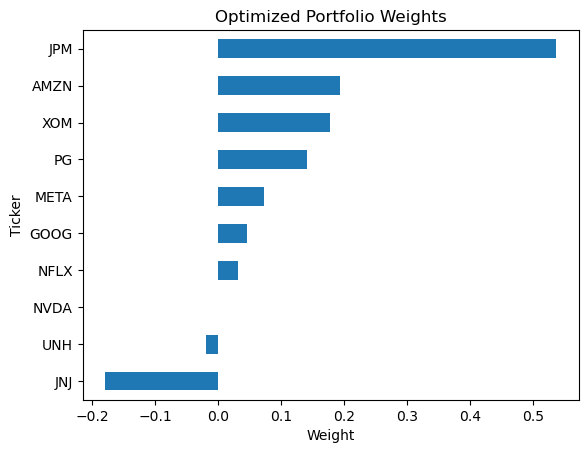

In [22]:
factor_model.plot_weights()

In [23]:
factor_model.w

,weights
AMZN,1.934730e-01
GOOG,4.543501e-02
JNJ,-1.799747e-01
JPM,5.364813e-01
META,7.315028e-02
NFLX,3.178165e-02
NVDA,-2.848392e-07
PG,1.414858e-01
UNH,-2.002500e-02
XOM,1.781929e-01


In [24]:
factor_model.mu

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
0,0.000833,0.000307,-0.000452,0.001049,0.000518,0.000259,-0.000012,0.000219,-0.000415,0.00021


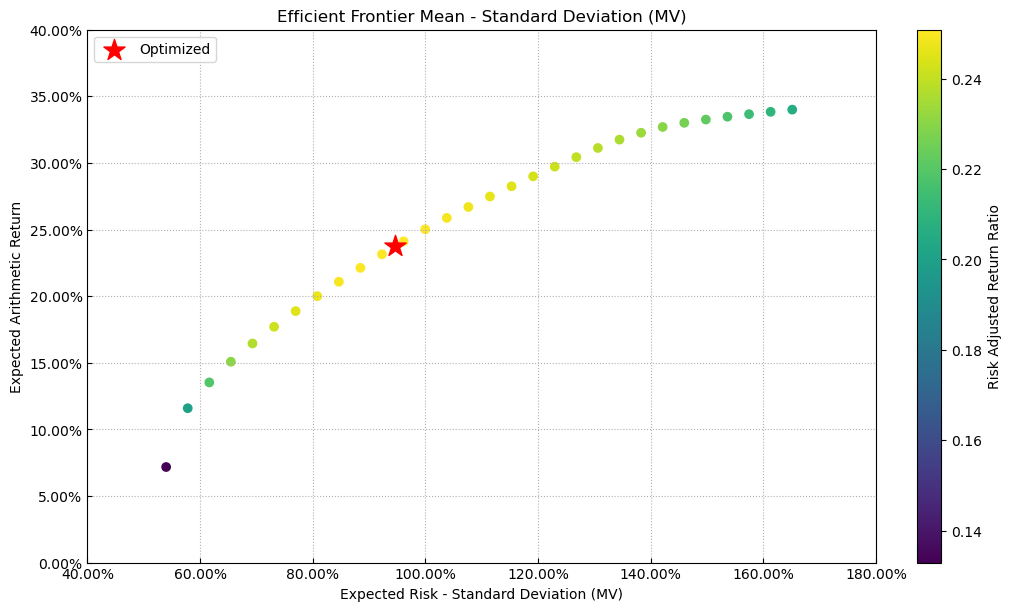

In [25]:
factor_model.plot_frontier()